In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import os
from shutil import copyfile
import random
import cv2
from sklearn.utils import shuffle
import seaborn as sns
import sys
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from glob import glob
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Conv2D , AveragePooling2D,Flatten,Dense , Activation , MaxPool2D, BatchNormalization , Dropout,ZeroPadding2D ,Input
from functools import partial
from keras.callbacks import ModelCheckpoint , LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

#Getting the Name of the Folders

In [2]:
dataPath = "/content/drive/MyDrive/Datasets/NWPU-RESISC45/"

classFolder = [name for name in os.listdir(dataPath) if os.path.isdir(os.path.join(dataPath,name))]
destFolder = ['training','testing']

In [3]:
classFolder[:10]

['tennis_court',
 'mobile_home_park',
 'church',
 'meadow',
 'airplane',
 'basketball_court',
 'wetland',
 'sparse_residential',
 'mountain',
 'overpass']

In [4]:
destFolder

['training', 'testing']

In [ ]:
to_create = {
    'train_root' : '/content/drive/MyDrive/Datasets/NWPU-RESISC45/training',
    'test_root' : '/content/drive/MyDrive/Datasets/NWPU-RESISC45/testing'
}

for directory in to_create.values():
  try:
    os.mkdir(directory)
    print(directory,'Created')
  except:
    print(directory,'Failed')

/content/drive/MyDrive/Datasets/NWPU-RESISC45/training Failed
/content/drive/MyDrive/Datasets/NWPU-RESISC45/testing Failed


#  Copying Files to Training and Testing folder

In [5]:
dataPath+destFolder[0]+'/'+classFolder[0]

'/content/drive/MyDrive/Datasets/NWPU-RESISC45/training/tennis_court'

In [ ]:
def split_data_copy_folder(commFolder,classFolder,destFolder,split_size):
  files = []

  for classF in classFolder[:10]:
    os.mkdir(commFolder + destFolder[0]+'/'+classF)
    os.mkdir(commFolder + destFolder[1]+'/'+classF)

    trainDir = commFolder + destFolder[0] + '/' + classF
    testDir = commFolder + destFolder[1] + '/' + classF

    for image in os.listdir(commFolder+classF):
      imagePath = os.path.join(commFolder+classF+'/'+image)
      if os.path.getsize(imagePath):
        files.append(image)
      else:
        print(f"{image} has zero size")
    
    total_files = len(files)
    split = int(total_files * split_size)
    shuffled = random.sample(files,total_files)
    train = shuffled[:split]
    test = shuffled[split:]

    for image in train:
      copyfile(os.path.join(commFolder,classF,image),os.path.join(trainDir,image))

    for image in test:
      copyfile(os.path.join(commFolder,classF,image),os.path.join(testDir,image))

    print(f"{classF} Done")
    files.clear()

In [ ]:
split_data_copy_folder(dataPath,classFolder,destFolder,0.7)

tennis_court Done
mobile_home_park Done
church Done
meadow Done
airplane Done
basketball_court Done
wetland Done
sparse_residential Done
mountain Done
overpass Done


# Loading Data

In [6]:
def loadingData(rootPath):
  categories = os.listdir(rootPath)
  X = []
  y = []

  for index , category in enumerate(categories):
    imgPath = os.path.join(rootPath, category)
    images = os.listdir(imgPath)
    
    for  image in images:
      img = cv2.imread(os.path.join(imgPath,image),1)
      img = cv2.resize(img,(224,224))
      
      X.append(img)
      y.append(index)
  return np.array(X),np.array(y)

In [7]:
X_train , y_train = loadingData(dataPath + '/' + destFolder[0])
X_test , y_test = loadingData(dataPath + '/' + destFolder[1])

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

# Memory of the Data



*   2.9 GB of Training Data



In [ ]:
X_train.nbytes * 1e-9

2.9443276800000002



*   1.27 GB of Validation Data



In [ ]:
X_test.nbytes * 1e-9

1.27045632

# Applying Singular Value Decomposition on a Sample Image

Text(0.5, 1.0, 'tennis_court')

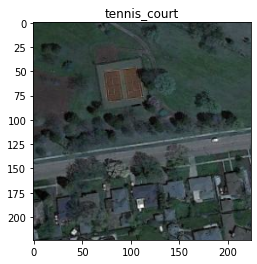

In [ ]:
plt.imshow(X_train[0])
plt.title(str(classFolder[y_test[0]]))

In [ ]:
gray_image = cv2.cvtColor(X_train[0],cv2.COLOR_BGR2GRAY)
img_mat = np.array(list(gray_image),float)

In [ ]:
img_mat.shape

(224, 224)

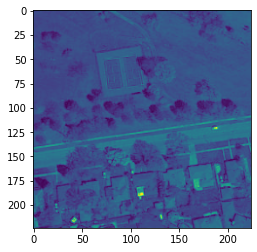

In [ ]:
plt.imshow(img_mat)

In [ ]:
sampleImage_scaled = (img_mat - img_mat.mean())/ (img_mat.std())

In [ ]:
U,s,V = np.linalg.svd(sampleImage_scaled)

In [ ]:
var_explained = np.round(s**2/np.sum(s**2),decimals = 3)

In [ ]:
var_explained.shape

(224,)

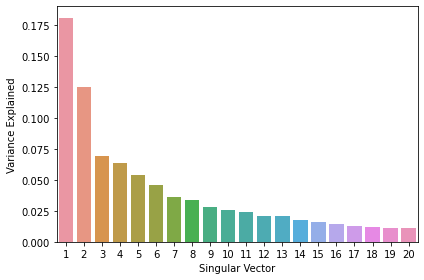

In [ ]:
sns.barplot(x=list(range(1,21)),y=var_explained[0:20])
plt.xlabel('Singular Vector')
plt.ylabel('Variance Explained')
plt.tight_layout()

In [ ]:
num_components = 5
reconst_img_5 = np.array(U[:,:num_components]).dot(np.diag(s[:num_components]).dot(np.array(V[:num_components,:])))

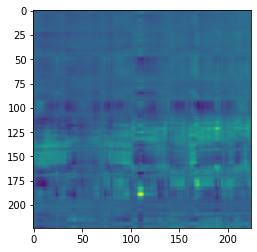

In [ ]:
plt.imshow(reconst_img_5)

In [ ]:
num_components = 80
reconst_img_5 = np.array(U[:,:num_components]).dot(np.diag(s[:num_components]).dot(np.array(V[:num_components,:])))

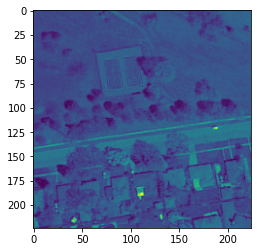

In [ ]:
plt.imshow(reconst_img_5)

In [ ]:
sys.getsizeof(img_mat)

401528

In [ ]:
sys.getsizeof(reconst_img_5)

401528

# Length of the Data

In [9]:
print(f"Length of the Training Set {len(X_train)}")
print(f"Length of the Training Set {len(X_test)}")

Length of the Training Set 4890
Length of the Training Set 2110


# Shape of the Data

In [10]:
X_train.shape

(4890, 224, 224, 3)

# Suffling the Training and Testing Set

In [11]:
X_train , y_train = shuffle(X_train,y_train)

In [12]:
X_test , y_test = shuffle(X_test,y_test)

In [13]:
y_train.shape

(4890,)

In [14]:
y_test.shape

(2110,)

# Image Generator

In [54]:
Imagedatagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


In [55]:
Imagedatagen.fit(X_train)

# Plotting Data

In [ ]:
def PlotData(dataX,dataY):
  fig = plt.figure(figsize = (20,20))

  for index in range(12):
    ax = fig.add_subplot(3,4,index + 1,xticks = [],yticks = [])
    ax.imshow(dataX[index])
    ax.set_title(str(classFolder[dataY[index]]))

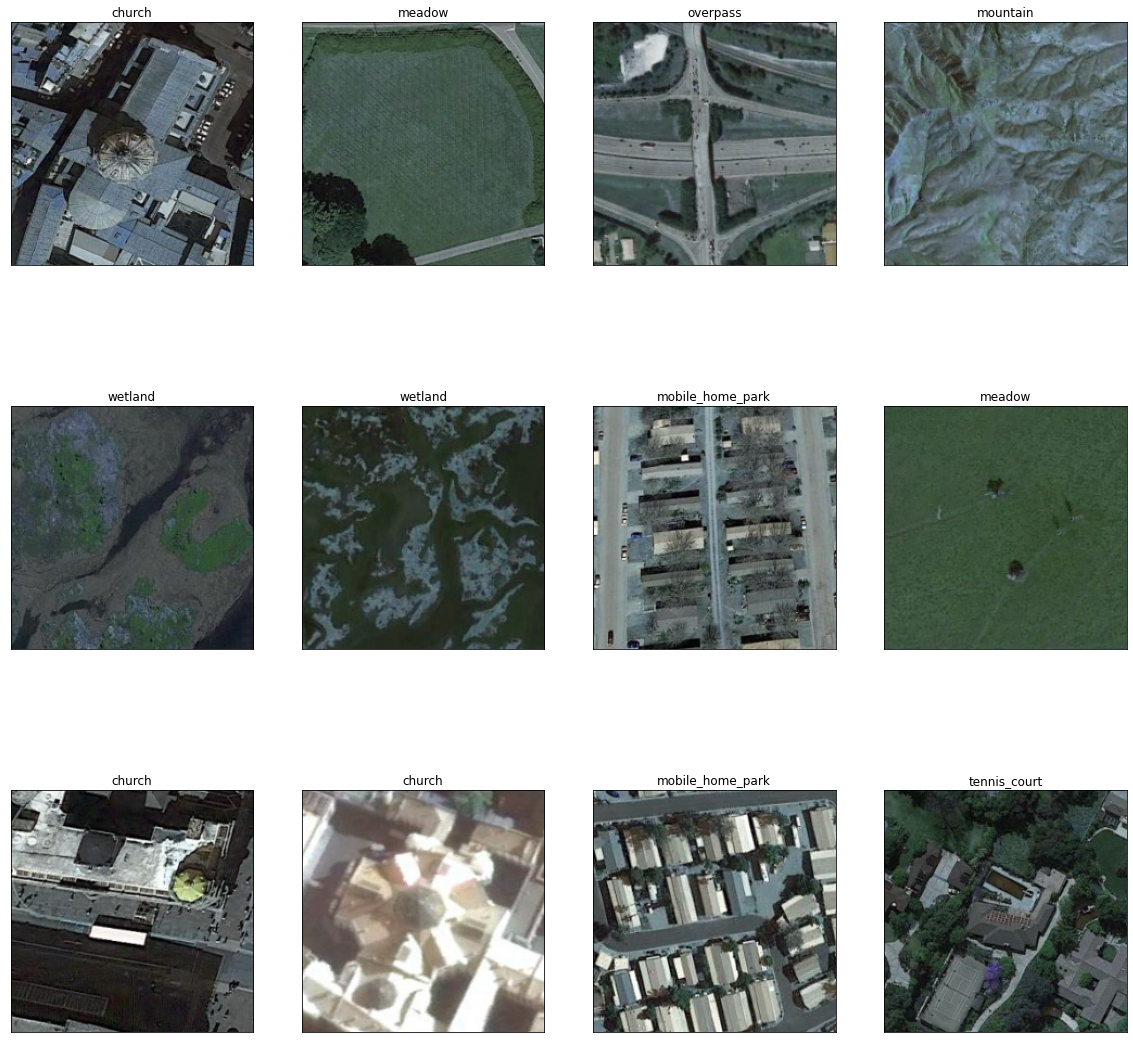

In [ ]:
PlotData(X_train,y_train)

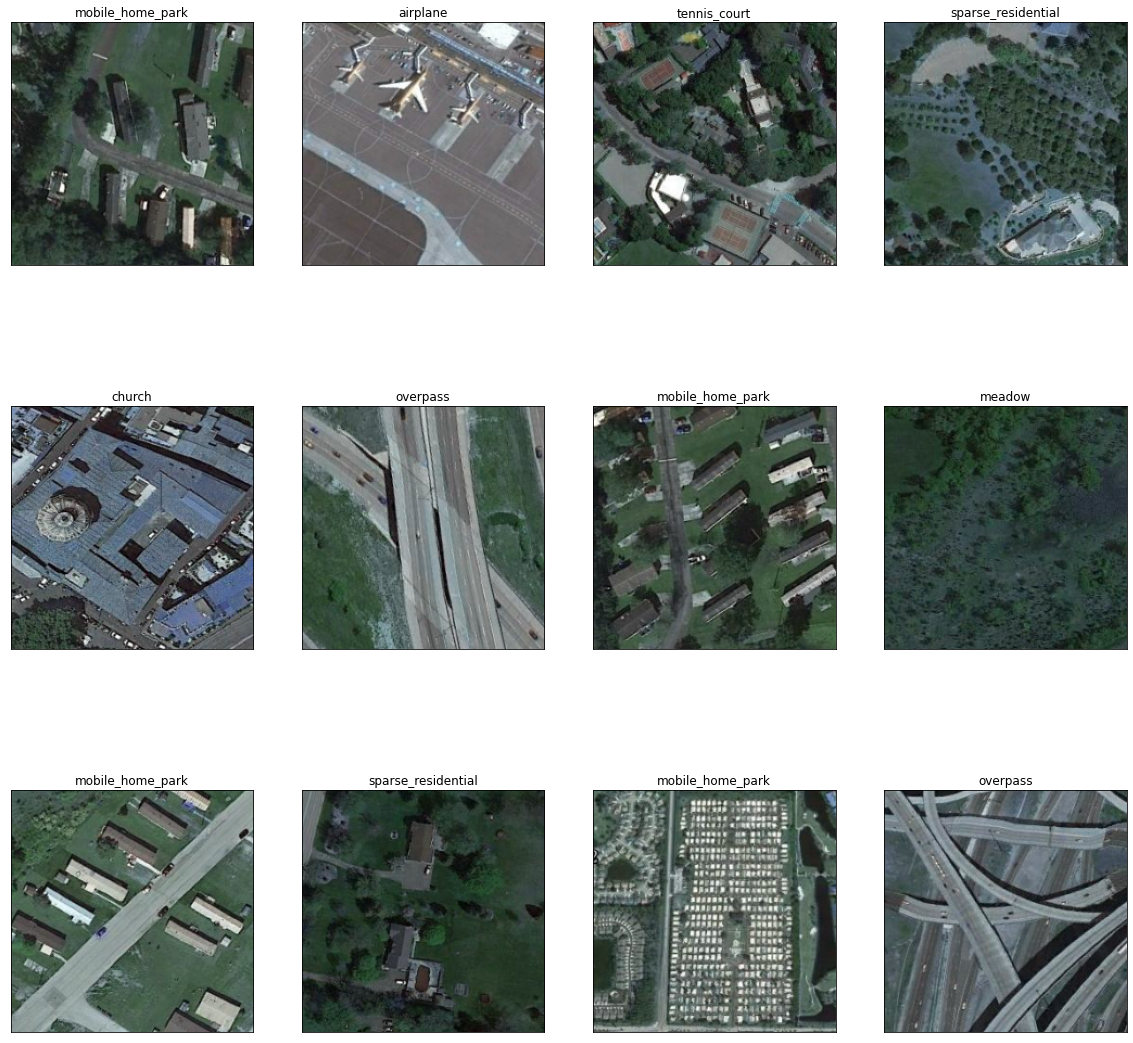

In [ ]:
PlotData(X_test,y_test)

In [15]:
depth = 10
y_train = tf.one_hot(y_train, depth)
y_test = tf.one_hot(y_test, depth)  

In [16]:
y_train.shape

TensorShape([4890, 10])

In [17]:
X_train.shape

(4890, 224, 224, 3)

# Visualization

In [ ]:
def PlotForModel(history,type):
  if(type == "accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
  elif (type == "loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
  else:
    print("Invalid Type")
  
  plt.title("model" + type)
  plt.ylabel(type)
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc = 'upper left')
  plt.show()

# Creating Class for Model

In [10]:
class ModelFunctionalities():
  def __init__(self,model,data,loss = 'categorical_crossentropy',optimizer ='sgd',metrics = 'accuracy',batch_size_train = 32,batch_size_validation = 8,epochs = 20,callbacks = None):
    self.model = model
    self.data = data
    self.loss = loss
    self.optimizer = optimizer
    self.metrics = metrics
    self.callbacks = callbacks
    self.batch_size_train = batch_size_train
    self.batch_size_validation = batch_size_validation
    self.epochs = epochs
    self.callbacks = []
    self.imagedatagen = self.DataAugmentation()

    if callbacks is None:
      checkpoint = ModelCheckpoint(filepath = 'TransferModel.h5', save_best_only = True)
      lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.01),cooldown = 0 , patience = 5,min_lr = 0.5e-5)
      self.callbacks = [checkpoint,lr_reducer]
  
  def DataAugmentation(self):
    Imagedatagen = ImageDataGenerator(featurewise_center=True,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2)
    Imagedatagen.fit(self.data[0])
    return Imagedatagen
  
  def CompileModel(self):
    self.model.compile(loss = self.loss,optimizer=self.optimizer,metrics = self.metrics)

  def FitModel(self):
    history = self.model.fit(self.imagedatagen.flow(self.data[0], self.data[1], batch_size=self.batch_size_train,
         subset='training'),
         validation_data=self.imagedatagen.flow(self.data[0], self.data[1],
         batch_size=self.batch_size_validation, subset="validation"),callbacks = self.callbacks,
         epochs=self.epochs)
    
  def ModelArchitectureFig(self):
      plotfig=tf.keras.utils.plot_model(self.model,f"{self.model}.png",show_shapes = True)
      return plotfig
  
  def EvaluateModel(self):
    score = self.model.evaluate(self.data[2],self.data[3])
    return score
  
  def ModelSummary(self):
    return self.model.summary()

## Creating Callbacks

In [3]:
K = tf.keras.backend
class  ExponentialDecay(tf.keras.callbacks.Callback):
  def __init__(self, s = 40000):
    super().__init__()
    self.s = s
  
  def on_batch_begin(self,batch,logs = None):
    lr = K.get_value(self.model.optimizer.learning_rate)
    K.set_value(self.model.optimizer.learning_rate , lr*0.1**(1/self.s))
  
  def on_epoch_end(self,epoch,logs = None):
    logs = logs or {}
    logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)

# Simple Model Architecture

In [21]:
modelCNN_1 = tf.keras.models.Sequential()
modelCNN_1.add(tf.keras.layers.Conv2D(10,kernel_size = (3,3),activation = 'relu',input_shape = (224,224,3)))
modelCNN_1.add(tf.keras.layers.BatchNormalization())
modelCNN_1.add(tf.keras.layers.Dropout(0.4))

modelCNN_1.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation = 'relu'))
modelCNN_1.add(tf.keras.layers.BatchNormalization())
modelCNN_1.add(tf.keras.layers.Dropout(0.4))

modelCNN_1.add(tf.keras.layers.Conv2D(10,kernel_size=(3,3),activation = 'relu'))
modelCNN_1.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))

modelCNN_1.add(tf.keras.layers.Conv2D(16,kernel_size = (3,3),activation = 'relu'))
modelCNN_1.add(tf.keras.layers.BatchNormalization())
modelCNN_1.add(tf.keras.layers.Dropout(0.4))

modelCNN_1.add(tf.keras.layers.Flatten())
modelCNN_1.add(tf.keras.layers.Dense(220,activation='relu'))

modelCNN_1.add(tf.keras.layers.Dense(10,activation = 'softmax'))

In [47]:
modelCNN_2 = tf.keras.models.Sequential()
modelCNN_2.add(tf.keras.layers.Conv2D(10,kernel_size = (3,3),activation = 'relu',input_shape = (224,224,3)))
modelCNN_2.add(tf.keras.layers.BatchNormalization())

modelCNN_2.add(tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation = 'relu'))
modelCNN_2.add(tf.keras.layers.BatchNormalization())

modelCNN_2.add(tf.keras.layers.Conv2D(10,kernel_size=(3,3),activation = 'relu'))
modelCNN_2.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))

modelCNN_2.add(tf.keras.layers.Conv2D(16,kernel_size = (3,3),activation = 'relu'))
modelCNN_2.add(tf.keras.layers.BatchNormalization())

modelCNN_2.add(tf.keras.layers.Flatten())
modelCNN_2.add(tf.keras.layers.Dense(220,activation='relu'))

modelCNN_2.add(tf.keras.layers.Dense(10,activation = 'softmax'))

# VGG Architecuture

In [4]:
modelVGG = Sequential()


#First Block
modelVGG.add(Conv2D(filters=64,kernel_size=(3,3),strides = (1,1),activation = 'relu',padding='same',input_shape = (224,224,3)))
modelVGG.add(Conv2D(filters=64,kernel_size = (3,3),strides = (1,1),activation = 'relu',padding='same'))
modelVGG.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))

#second Block
modelVGG.add(Conv2D(filters=128,kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 128,kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

#third block
modelVGG.add(Conv2D(filters = 256 , kernel_size = (3,3) , strides = (1,1), activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 256, kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 256, kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

#Fourth Block
modelVGG.add(Conv2D(filters = 512, kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 512, kernel_size = (3,3),strides = (1,1),activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 512 , kernel_size = (3,3), strides = ( 1,1),activation = 'relu',padding = 'same'))
modelVGG.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

#fifth Block
modelVGG.add(Conv2D(filters = 512 , kernel_size = (3,3),strides = (1,1) ,activation = 'relu',padding = 'same'))
modelVGG.add(Conv2D(filters = 512 , kernel_size = (3,3),strides = (1,1),activation = 'relu' , padding = 'same'))
modelVGG.add(Conv2D(filters = 512 , kernel_size = (3,3),strides = (1,1),activation = 'relu' , padding = 'same'))
modelVGG.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

# Classifier
modelVGG.add(Flatten())
modelVGG.add(Dense(256, activation = 'relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(256,activation = 'relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(10,activation = 'softmax'))

# In the right direction , Let's tweak Optimizer

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01,momentum = 0.9,nesterov= True,name='SGD')

# Adding Residual Network

In [ ]:
from functools import partial
from keras.callbacks import ModelCheckpoint , LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size = 3,activation = 'relu',padding='SAME')

class ResidualNetwork(tf.keras.layers.Layer):
  def __init__(self,filters,strides = 1, activation = "relu",**kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
                        DefaultConv2D(filters , strides = strides),
                        tf.keras.layers.BatchNormalization(),
                        self.activation,
                        DefaultConv2D(filters),
                        tf.keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
                          DefaultConv2D(filters , kernel_size = 1, strides = strides),
                          tf.keras.layers.BatchNormalization()]
  
  def call(self,inputs):
    X = inputs
    for layer in self.main_layers:
      X = layer(X)
    skip_X = inputs

    for layer in self.skip_layers:
      skip_X = layer(skip_X)
    return self.activation(X + skip_X)

  def get_config(self):
    base_config = super().get_config()
    return {**base_config , "activation":self.activation}

# Squeeze Excitation Layer

In [100]:
class SqueezeExcitationLayer(tf.keras.layers.Layer):
  def __init__(self,filters,reductionRatio,activation = "relu",**kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.SenetLayer = [
                       tf.keras.layers.Dense(filters/reductionRatio,kernel_initializer = "he_normal"),
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.Dense(filters,kernel_initializer = "he_normal"),
    ]

    def call(self,inputs):
      X = inputs
      for layer in self.SenetLayer:
        X = layer(X)
      X = tf.keras.activations.sigmoid(X)
      
      X = tf.reshape(X,[-1,1,1,filters])
      scale = inputs * X
      return scale
    
    def get_config(self):
      base_config = super().get_config()
      return {**base_config , "activation":self.activation}

# Creating GoogleNet architecture

## Kernel and Bias Initializer

In [ ]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value = 0.2)

## Inception Module

In [102]:
from keras.backend import concatenate
def inceptionModule(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
  conv1x1 = Conv2D(filters_1x1,(1,1),padding="same",activation = 'relu',kernel_initializer= kernel_init,bias_initializer=bias_init)(x)

  conv3x3 = Conv2D(filters_3x3_reduce,(1,1),padding="same",activation = 'relu',kernel_initializer= kernel_init,bias_initializer=bias_init)(x)
  conv3x3 = Conv2D(filters_3x3,(3,3),padding="same",activation = 'relu',kernel_initializer= kernel_init,bias_initializer=bias_init)(conv3x3)

  conv5x5 = Conv2D(filters_5x5_reduce,(1,1),padding="same",activation = 'relu',kernel_initializer= kernel_init,bias_initializer=bias_init)(x)
  conv5x5 = Conv2D(filters_5x5_reduce,(5,5),padding="same",activation = 'relu',kernel_initializer= kernel_init,bias_initializer=bias_init)(conv5x5)

  pool_proj = MaxPool2D((3,3),strides = (1,1),padding = 'same')(x)
  pool_proj = Conv2D(filters_pool_proj,(1,1),padding = 'same' , activation = 'relu' , kernel_initializer=kernel_init,bias_initializer = bias_init)(pool_proj)

  output = tf.concat([conv1x1,conv3x3,conv5x5,pool_proj],axis = 3 , name=name)

  return output

In [ ]:
input_layer = Input(shape = (224,224,3))
x = Conv2D(64,(7,7),padding = 'same' ,strides = (2,2),activation='relu',name = 'conv_1_7x7_2',kernel_initializer=kernel_init,bias_initializer = bias_init)(input_layer)
x = MaxPool2D((3,3),padding = 'same' , strides = (2,2),name = 'max_pool_1_3x3/2')(x)
x = Conv2D(192,(3,3),padding = 'same' , strides = (1,1),activation = 'relu',name='conv_2b_3x3/1')(x)
x = MaxPool2D((3,3),padding='same',strides = (2,2),name = 'max_pool_2_3x3/2')(x)

x = inceptionModule(x,filters_1x1 = 64,filters_3x3_reduce = 96,filters_3x3 = 128,filters_5x5_reduce = 16,filters_5x5 = 32,filters_pool_proj = 32,name='inception_3a')
x = inceptionModule(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,filters_5x5_reduce=32,filters_5x5=96,filters_pool_proj= 64,name='inception_3b')

x = MaxPool2D((3,3),padding='same',strides = (2,2),name = 'max_pool_3_3x3/2')(x)

x = inceptionModule(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,filters_5x5_reduce=32,filters_5x5=96,filters_pool_proj= 64,name='inception_4a')

classifier_1 = AveragePooling2D((5,5),strides = 3)(x)
classifier_1 = Conv2D(128,(1,1),padding='same',activation = 'relu')(classifier_1)
classifier_1 = Flatten()(classifier_1)
classifier_1 = Dense(1024,activation = 'relu')(classifier_1)
classifier_1 = Dropout(0.7)(classifier_1)
classifier_1 = Dense(10,activation = 'softmax',name = 'auxiliary_output_1')(classifier_1)

x = inceptionModule(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj= 64,name='inception_4b')
x = inceptionModule(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj= 64,name='inception_4c')
x = inceptionModule(x,filters_1x1=112,filters_3x3_reduce=144,filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64,filters_pool_proj= 64,name='inception_4d')

classifier_2 = AveragePooling2D((5,5),strides = 3)(x)
classifier_2 = Conv2D(128,(1,1),padding='same',activation = 'relu')(classifier_2)
classifier_2 = Flatten()(classifier_2)
classifier_2 = Dense(1024,activation = 'relu')(classifier_2)
classifier_2 = Dropout(0.7)(classifier_2)
classifier_2 = Dense(10,activation = 'softmax',name = 'auxiliary_output_1')(classifier_2)

x = MaxPool2D((3,3),padding='same',strides = (2,2),name = 'max_pool_4_3x3/2')(x)
x = inceptionModule(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,filters_pool_proj= 128,name='inception_5a')
x = inceptionModule(x,filters_1x1=384,filters_3x3_reduce=192,filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128,filters_pool_proj= 128,name='inception_5b')

x = AveragePooling2D((7,7),padding='valid',strides = (1,1),name = 'avg_pool_5_3x3/1')(x)

x = Flatten()(x)
x = Dense(0.4)(x)
x = Dense(256,activation = 'relu' , name = 'linear')(x)
output = Dense(10, activation = 'softmax',name = 'output')(x)

In [103]:
modelFunctionAPIs = tf.keras.models.Model(inputs = [input_layer],outputs = [output])

# Transfer Learning

In [76]:
IMAGE_SIZE = [224,224]

In [77]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3],weights = 'imagenet',include_top = False)

58900480/58889256 [==============================] - 1s 0us/step


In [78]:
for layer in vgg.layers:
  layer.trainable = False

In [79]:
folders = glob('/content/drive/MyDrive/Datasets/NWPU-RESISC45/training/*')
print(len(folders))

10


In [80]:
x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(len(folders),activation = 'softmax')(x)
model = tf.keras.models.Model(inputs=vgg.input,outputs=prediction)

# InceptionV3

In [92]:
model = InceptionV3(input_shape = IMAGE_SIZE + [3],weights = 'imagenet',include_top = False)

In [93]:
for layer in model.layers:
  layer.trainable = False

In [94]:
x = tf.keras.layers.Flatten()(model.output)
prediction = tf.keras.layers.Dense(len(folders),activation = 'softmax')(x)
model = tf.keras.models.Model(inputs=model.input,outputs=prediction)

In [95]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)

In [98]:
model.compile(loss="categorical_crossentropy",optimizer = sgd , metrics = ['accuracy'])

# Learning Rate Scheduling

In [ ]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1 ** (epoch / 20)

In [ ]:
def exponential_decay(lr0,s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 **(epoch/s)
  return exponential_decay_fn

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
callbacks = [checkpoint,lr_scheduler]

In [ ]:
x = tf.keras.layers.Flatten()(vgg.output)
hidden1 = tf.keras.layers.Dense(512,activation = 'relu')(x)
hidden2 = tf.keras.layers.Dense(256,activation = 'relu')(hidden1)
prediction = tf.keras.layers.Dense(len(folders),activation = 'softmax')(hidden2)
model = tf.keras.models.Model(inputs=vgg.input,outputs=prediction)